Convolutional Neural Network (CNN) implementation for Diabetic Retinopathy Detection 
https://www.kaggle.com/c/diabetic-retinopathy-detection/data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 
from keras import regularizers
from keras import optimizers

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

I have already downloaded the dataset from Kaggle.
I have noted all the steps to download the database in a seperate file.
Below I am loading a CSV file containing training labels 

In [4]:
df_csv = pd.read_csv('/storage/trainLabels.csv')

Since these labels dont have .jpeg extension, lets add it to the dataframe

In [5]:
df_csv['image'] = df_csv['image'].astype(str) + '.jpeg'

There are 35125 images in the training set, 'level' is the column indicating the labels for its respective images

In [6]:
df_csv.tail()

,image,level
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0
35125,44349_right.jpeg,1


It is important to remove all imgaes of size 0 KB, below command will print all files of size zero. Replace print with delete to delete those images. Dont forget to cd into train directory 

In [7]:
!find /storage/train/ -size 0 -print

Make a list of all images after deleating size zero images.

In [8]:
#!ls -1 >> /storage/name.txt

Read all the content into a dataframe

In [9]:
df = pd.read_table('/storage/name.txt',  header=None)

In [10]:
df.columns = ['name']

In [11]:
df.tail()

,name
31974,6483_left.jpeg
31975,6483_right.jpeg
31976,6484_left.jpeg
31977,6484_right.jpeg
31978,6488_left.jpeg


Remove the image entries from df_csv which we just deleted from \train folder

In [12]:
df_train = df_csv[df_csv.image.isin(df.name.values)]

In [13]:
df_train.tail()

,image,level
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0
35125,44349_right.jpeg,1


Only 31979 images left after removing unwanted images.

In [14]:
df_train.shape

(31979, 2)

There are 5 types of labels 0/1/2/3/4, they are distinguished as below
NDPR - Non Proliferative Diabetic Retinopathy

Class	 Name
0	    Normal	
1	    Mild NPDR
2	    Moderate NPDR
3	    Severe NPDR	
4	    PDR

Image data generator can be used to pre processes images before training. 
This function can be used to perform image augmentation, chnage brightness, horizontal/vertical flip, image roration, etc.
https://keras.io/preprocessing/image/

In [15]:
TrainData = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True)

In [16]:
ValidData = ImageDataGenerator(
    horizontal_flip=True)

Its important to split the whole dataset into training and validation dataset apart from testing dataset which we have seperately.

In [17]:
train, valid = train_test_split(df_train, test_size=0.1, random_state=1)

In [18]:
train.shape

(28781, 2)

In [19]:
valid.head()

,image,level
298,349_left.jpeg,0
2209,2735_right.jpeg,0
30221,38224_right.jpeg,0
9545,12003_right.jpeg,2
12554,15745_left.jpeg,0


In [20]:
valid.shape

(3198, 2)

flow_from_dataframe function can be used to read labels from dataframe and images from /storage/train/ directory. Image and level are the column names of df_train dataframe. Class_mode is 'other' since we are not using one hot encoding for labels.  

In [28]:
train_generator = TrainData.flow_from_dataframe(
            dataframe=train, directory="/storage/train/", 
            x_col="image", y_col="level", 
            class_mode="other", target_size=(256,256), 
            batch_size= 64)

Found 28781 images.


In [29]:
valid_generator = ValidData.flow_from_dataframe(
            dataframe=valid, directory="/storage/train/", 
            x_col="image", y_col="level", 
            class_mode="other", target_size=(256,256), 
            batch_size=32)

Found 3198 images.


Now we will define the model >>
The model has 2 convolutional leyers, 2 max pooling layes, image flattening layer and a dence layer
Models in Keras/TF come in 2 forms - Sequential (model = Sequential()) or using Funtional API
Below code is using Funtional API which is usually used for complex models, i will leave the light weight Sequential() model in comments

In [35]:
visible = Input(shape=(256,256,3))
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
conv3 = ZeroPadding2D(padding=(1, 1))(conv2)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv3)
#bat1 = BatchNormalization(axis = 1)(pool1)

conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool1)
conv5 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(conv4)
pool2 = MaxPooling2D(pool_size=(1, 1))(conv5)

conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(pool2)
conv7 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv6)
conv7 = ZeroPadding2D(padding=(1, 1))(conv7)
pool3 = MaxPooling2D(pool_size=(1, 1))(conv7)

conv8 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(pool3)
conv9 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv8)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv9)

flat = Flatten()(pool4)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.3)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(5, activation='sigmoid')(drop2)
#output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)

There are variety of optimizers available >> https://keras.io/optimizers/
More about loss functions >> https://keras.io/losses/
Metrics >> https://keras.io/metrics/

In [36]:
opt = optimizers.adam(lr=0.01, decay=0.0)

In [37]:
model.compile(optimizer= opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 123, 123, 32)      9248      
__________

In [39]:
with tf.device('/device:GPU:0'): 
    m1= model.fit_generator(
            train_generator,
            epochs=5,
            validation_data=valid_generator,
            verbose=1)

Epoch 1/5
450/450 [==============================] - 6337s 14s/step - loss: 3.5789 - acc: 0.7344 - val_loss: 4.1605 - val_acc: 0.7420
Epoch 2/5
450/450 [==============================] - 5914s 13s/step - loss: 4.7468 - acc: 0.7355 - val_loss: 4.1846 - val_acc: 0.7420
Epoch 3/5
450/450 [==============================] - 4759s 11s/step - loss: 6.3688 - acc: 0.7356 - val_loss: 5.8445 - val_acc: 0.7420
Epoch 4/5
450/450 [==============================] - 4495s 10s/step - loss: 5.4294 - acc: 0.7355 - val_loss: 4.9525 - val_acc: 0.7420
Epoch 5/5
450/450 [==============================] - 4361s 10s/step - loss: 4.8399 - acc: 0.7355 - val_loss: 4.5643 - val_acc: 0.7420


Lets plot training and validation loss and accuracy. Before usinng below line import plot_history() function.

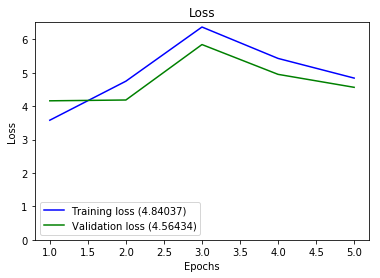

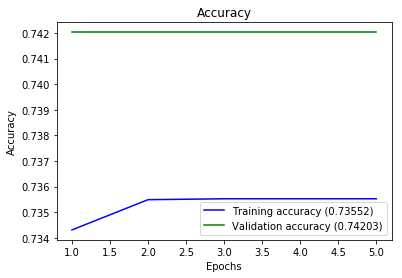

In [49]:
plot_history(m1)

In [48]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    #plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.ylim(0, 1)    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
     print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
     print("Please install GPU version of TF")